# Fit $y=sin(x)$ with a third order polynomial

In PyTorch, the nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

## `nn` package

In [1]:
import torch
import math

In [2]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)
print(f"x= {x}\n")
print(f"y= {y}\n")
print(x.shape, y.shape)

x= tensor([-3.1416, -3.1384, -3.1353,  ...,  3.1353,  3.1384,  3.1416])

y= tensor([ 8.7423e-08, -3.1430e-03, -6.2863e-03,  ...,  6.2863e-03,
         3.1432e-03, -8.7423e-08])

torch.Size([2000]) torch.Size([2000])


For this example, the output y is a linear function of $(x, x^2, x^3)$, so we can consider it as a linear layer neural network. Let's prepare the tensor $(x, x^2, x^3)$.

In [3]:
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)
print(f"x.unsqueeze(-1) =\n {x.unsqueeze(-1)}\n")
print(f"x.unsqueeze(-1).shape = {x.unsqueeze(-1).shape}\n")
print(f"xx = {xx}\n")
print(f"xx.shape = {xx.shape}\n")

x.unsqueeze(-1) =
 tensor([[-3.1416],
        [-3.1384],
        [-3.1353],
        ...,
        [ 3.1353],
        [ 3.1384],
        [ 3.1416]])

x.unsqueeze(-1).shape = torch.Size([2000, 1])

xx = tensor([[ -3.1416,   9.8696, -31.0063],
        [ -3.1384,   9.8499, -30.9133],
        [ -3.1353,   9.8301, -30.8205],
        ...,
        [  3.1353,   9.8301,  30.8205],
        [  3.1384,   9.8499,  30.9133],
        [  3.1416,   9.8696,  31.0063]])

xx.shape = torch.Size([2000, 3])



Use the nn package to define our model as a sequence of layers.   
`nn.Sequential` is a Module which contains other Modules, and applies them in sequence to produce its output. The Linear Module computes output from input using a linear function, and holds internal Tensors for its weight and bias.  
The Flatten layer flatens the output of the linear layer to a 1D tensor, to match the shape of `y`.

In [4]:
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)# Flattens a contiguous range of dims into a tensor.                                      torch.nn.Flatten(start_dim: int = 1, end_dim: int = -1)
)

The nn package also contains definitions of popular loss functions; in this case we will use Mean Squared Error (MSE) as our loss function.

In [5]:
loss_fn = torch.nn.MSELoss(reduction='sum')

In [6]:
learning_rate = 1e-6

In [7]:
for t in range(3000):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(xx)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 200 == 199:
        print(f"{t+1}-th epoch: MSE = {loss.item()}") # '.item()' is to obtain its value

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

200-th epoch: MSE = 905.8662719726562
400-th epoch: MSE = 402.9305114746094
600-th epoch: MSE = 182.0838165283203
800-th epoch: MSE = 85.04901123046875
1000-th epoch: MSE = 42.38545227050781
1200-th epoch: MSE = 23.612943649291992
1400-th epoch: MSE = 15.345804214477539
1600-th epoch: MSE = 11.701425552368164
1800-th epoch: MSE = 10.093147277832031
2000-th epoch: MSE = 9.382526397705078
2200-th epoch: MSE = 9.06808853149414
2400-th epoch: MSE = 8.928747177124023
2600-th epoch: MSE = 8.866888999938965
2800-th epoch: MSE = 8.839372634887695
3000-th epoch: MSE = 8.827112197875977


In [8]:
# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]
print(linear_layer)
print(linear_layer.bias)
print(linear_layer.weight)

Linear(in_features=3, out_features=1, bias=True)
Parameter containing:
tensor([0.0014], requires_grad=True)
Parameter containing:
tensor([[ 8.5397e-01, -2.4788e-04, -9.2937e-02]], requires_grad=True)


In [9]:
# For linear layer, its parameters are stored as `weight` and `bias`.
print(f'The third order polynomial aproximation of sine function is :\n\ty = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

The third order polynomial aproximation of sine function is :
	y = 0.0014368174597620964 + 0.8539739847183228 x + -0.0002478751994203776 x^2 + -0.09293682873249054 x^3


In [10]:
import matplotlib.pyplot as plt 
import numpy as np 
import math

x_np = x.detach().numpy()
y_pred_np = y_pred.detach().numpy()

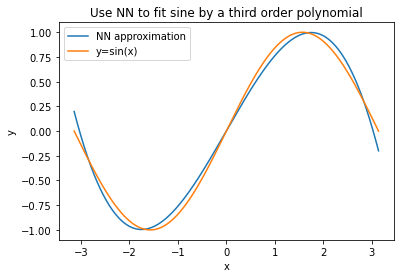

In [11]:
plt.figure()
plt.plot(x_np, y_pred_np, label='NN approximation') 
plt.plot(x_np, np.sin(x_np), label='y=sin(x)') 
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Use NN to fit sine by a third order polynomial")
plt.show()

___

## Optim package

Up to this point we have updated the weights of our models by manually mutating the Tensors holding learnable parameters with `torch.no_grad()`. This is not a huge burden for simple optimization algorithms like stochastic gradient descent, but in practice we often train neural networks using more sophisticated optimizers like **Adagrad, RMSProp, Adam**, etc.

The optim package in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms.

In this example we will use the nn package to define our model as before, but we will optimize the model using the RMSprop algorithm provided by the optim package:

In [12]:
import torch
import math


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Prepare the input tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

In [13]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
for t in range(3000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(xx)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 200 == 199:
        print(f"{t+1}-th epoch: MSE = {loss.item()}")

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()


linear_layer = model[0]
print(f'The third order polynomial aproximation of sine function is :\n\ty = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

200-th epoch: MSE = 11084.0458984375
400-th epoch: MSE = 2702.912841796875
600-th epoch: MSE = 1795.74365234375
800-th epoch: MSE = 1300.1849365234375
1000-th epoch: MSE = 884.49853515625
1200-th epoch: MSE = 567.79638671875
1400-th epoch: MSE = 330.41302490234375
1600-th epoch: MSE = 164.8553924560547
1800-th epoch: MSE = 64.73673248291016
2000-th epoch: MSE = 19.500205993652344
2200-th epoch: MSE = 9.276893615722656
2400-th epoch: MSE = 8.919900894165039
2600-th epoch: MSE = 8.91881275177002
2800-th epoch: MSE = 8.921417236328125
3000-th epoch: MSE = 8.920509338378906
The third order polynomial aproximation of sine function is :
	y = -0.0005010199965909123 + 0.8562425971031189 x + -0.0005010294844396412 x^2 + -0.09382958710193634 x^3


In [15]:
import matplotlib.pyplot as plt 
import numpy as np 
import math

x_np = x.detach().numpy()
y_pred_np = y_pred.detach().numpy()

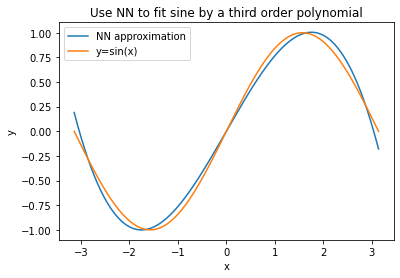

In [16]:
plt.figure()
plt.plot(x_np, y_pred_np, label='NN approximation') 
plt.plot(x_np, np.sin(x_np), label='y=sin(x)') 
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Use NN to fit sine by a third order polynomial")
plt.show()

___

## Consider a multi-layer network  
Next, we don't use the third order polynomial approximation, instead, we only want to see how multi-layer NN can approximate the sine function.

In [17]:
import torch
import math


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

xx = x.unsqueeze(-1)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential( # Have one hidden layer
    torch.nn.Linear(1, 3),
    torch.nn.ReLU(), # Use ELU activation function
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(20000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(xx)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 200 == 199:
        print(f"{t+1}-th epoch: MSE = {loss.item()}")

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()


linear_layer_0 = model[0]
print(linear_layer_0)
print(linear_layer_0.bias)
print(linear_layer_0.weight)
# 'model[1]' is the ELU function
linear_layer_1 = model[2]
print(linear_layer_1)
print(linear_layer_1.bias)
print(linear_layer_1.weight)

200-th epoch: MSE = 222.1185302734375
400-th epoch: MSE = 163.39878845214844
600-th epoch: MSE = 114.3281478881836
800-th epoch: MSE = 82.08216857910156
1000-th epoch: MSE = 66.6541976928711
1200-th epoch: MSE = 51.417076110839844
1400-th epoch: MSE = 38.91912078857422
1600-th epoch: MSE = 29.173322677612305
1800-th epoch: MSE = 22.206064224243164
2000-th epoch: MSE = 16.30120277404785
2200-th epoch: MSE = 10.724164009094238
2400-th epoch: MSE = 7.6106367111206055
2600-th epoch: MSE = 6.814985752105713
2800-th epoch: MSE = 6.6911115646362305
3000-th epoch: MSE = 6.647377967834473
3200-th epoch: MSE = 6.6219401359558105
3400-th epoch: MSE = 6.610921859741211
3600-th epoch: MSE = 6.602062702178955
3800-th epoch: MSE = 6.596940517425537
4000-th epoch: MSE = 6.596714019775391
4200-th epoch: MSE = 6.592458724975586
4400-th epoch: MSE = 6.591907501220703
4600-th epoch: MSE = 6.593267440795898
4800-th epoch: MSE = 6.591717720031738
5000-th epoch: MSE = 6.592395305633545
5200-th epoch: MSE = 6

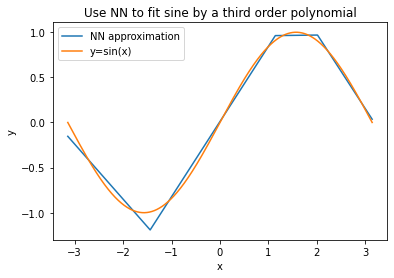

In [18]:
import matplotlib.pyplot as plt 
import numpy as np 
import math

x_np = x.detach().numpy()
y_pred_np = y_pred.detach().numpy()

plt.figure()
plt.plot(x_np, y_pred_np, label='NN approximation') 
plt.plot(x_np, np.sin(x_np), label='y=sin(x)') 
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Use NN to fit sine by a third order polynomial")
plt.show()